# TODO:
- trzeba się zastanowić jakie zakres hyper parametrów bierzemy - ADAM -TODO
- sprawdić jak zmiana seed w random search wpływa na wyniki tunowalnośći (sampling bias) - TODO (zmienaimy seed i patrzymy czy tunowalność się zmienia -> tabelka z 10 seedami i patrzyma jak zmienia się tunowalnosć) -TODO ( przy pisaniu raportu)

### Imports

In [1]:
import itertools
import random
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from skopt.space import Integer, Real

from utills.best_config_bayes import (
    find_best_config_using_bayes,
    find_best_configs_in_search_space_with_bayes,
)
from utills.best_config_random_search import (
    find_best_configs_in_search_space_with_random_search,
)
from utills.dataset import load_dataset_from_id, split_dataset
from utills.dump_data import (
    dump_optimal_config_search_history,
    dump_scores_to_csv,
    dump_tunability_to_csv,
)
from utills.optimal_config import find_optimal_configuration_for_all_datasets
from utills.pipeline import get_column_transformer
from utills.tunability import (
    calculate_aggregate_tunability,
    calculate_tunability_on_each_dataset,
)

# Constants

In [27]:
NUM_ITER_BAYES = 50
NUM_POINTS_RS_DECISION_TREE = 50
NUM_POINTS_RS_ELASTIC_NET = 50
NUM_POINTS_RS_RANDOM_FOREST = 50
SEED = 42

### Utill functions

### Load datasets

In [3]:
fish_market_dataset_id = (
    43308  # https://www.openml.org/search?type=data&id=43308&sort=runs&status=active
)
cars_dataset_id = (
    44994  # https://www.openml.org/search?type=data&status=active&id=44994
)
diabetes_dataset_id = (
    44223  # https://www.openml.org/search?type=data&id=44223&sort=runs&status=active
)

lisbona_house_prices_dataset_id = (
    43660  # https://www.openml.org/search?type=data&id=43660&sort=runs&status=active
)

rmftsa_ladata_dataset_id = (
    666  # https://www.openml.org/search?type=data&status=active&id=666
)
boston_dataset_id = 531  # https://www.openml.org/search?type=data&status=active&id=531

treasury_dataset_id = (
    42367  # https://www.openml.org/search?type=data&status=active&id=42367
)

bank32nh_dataset_id = (
    558  # https://www.openml.org/search?type=data&status=active&id=558
)

puma32H_dataset_id = 308  # https://www.openml.org/search?type=data&status=active&id=308

fish_market_dataset: DataFrame = load_dataset_from_id(id=fish_market_dataset_id)
fish_market_regression_class = "Weight"

cars_dataset: DataFrame = load_dataset_from_id(id=cars_dataset_id)
cars_regression_class = "Price"

diabetes_dataset: DataFrame = load_dataset_from_id(id=diabetes_dataset_id)
diabetes_regression_class = "class"

lisbona_house_prices_dataset: DataFrame = load_dataset_from_id(
    id=lisbona_house_prices_dataset_id
)
lisbona_house_prices_regression_class = "Price"

rmftsa_ladata_dataset = load_dataset_from_id(id=rmftsa_ladata_dataset_id)
rmftsa_ladata_regression_class = "Respiratory_Mortality"

boston_dataset = load_dataset_from_id(id=boston_dataset_id)
boston_regression_class = "MEDV"

treasury_dataset = load_dataset_from_id(id=treasury_dataset_id)
treasury_regression_class = "1MonthCDRate"

bank32nh_dataset = load_dataset_from_id(id=bank32nh_dataset_id)
bank32nh_regression_class = "rej"

puma32H_dataset = load_dataset_from_id(id=puma32H_dataset_id)
puma32H_regression_class = "thetadd6"

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` 

### Split data into train and test sets

In [4]:
(
    X_train_fish_market,
    X_test_fish_market,
    y_train_fish_market,
    y_test_fish_market,
) = split_dataset(data=fish_market_dataset, class_=fish_market_regression_class)

(
    X_train_cars,
    X_test_cars,
    y_train_cars,
    y_test_cars,
) = split_dataset(data=cars_dataset, class_=cars_regression_class)

X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = split_dataset(
    diabetes_dataset, diabetes_regression_class
)

(
    X_train_lisbona_house_prices,
    X_test_lisbona_house_prices,
    y_train_lisbona_house_prices,
    y_test_lisbona_house_prices,
) = split_dataset(lisbona_house_prices_dataset, lisbona_house_prices_regression_class)

(
    X_train_rmftsa_ladata,
    X_test_rmftsa_ladata,
    y_train_rmftsa_ladata,
    y_test_rmftsa_ladata,
) = split_dataset(rmftsa_ladata_dataset, rmftsa_ladata_regression_class)

X_train_boston, X_test_boston, y_train_boston, y_test_boston = split_dataset(
    boston_dataset, boston_regression_class
)

X_train_treasury, X_test_treasury, y_train_treasury, y_test_treasury = split_dataset(
    treasury_dataset, treasury_regression_class
)

X_train_bank32nh, X_test_bank32nh, y_train_bank32nh, y_test_bank32nh = split_dataset(
    bank32nh_dataset, bank32nh_regression_class
)

X_train_puma32H, X_test_puma32H, y_train_puma32H, y_test_puma32H = split_dataset(
    puma32H_dataset, puma32H_regression_class
)

In [5]:
def get_train_datasets() -> List[Tuple[DataFrame, Series]]:
    return [
        (X_train_fish_market, y_train_fish_market),
        (X_train_cars, y_train_cars),
        (X_train_diabetes, y_train_diabetes),
        (X_train_lisbona_house_prices, y_train_lisbona_house_prices),
        (X_train_rmftsa_ladata, y_train_rmftsa_ladata),
        (X_train_boston, y_train_boston),
        (X_train_treasury, y_train_treasury),
    ]

In [6]:
def get_test_datasets():
    return [
        (X_test_fish_market, y_test_fish_market),
        (X_test_cars, y_test_cars),
        (X_test_diabetes, y_test_diabetes),
        (X_test_lisbona_house_prices, y_test_lisbona_house_prices),
        (X_test_rmftsa_ladata, y_test_rmftsa_ladata),
        (X_test_boston, y_test_boston),
        (X_test_treasury, y_test_treasury),
    ]


# 1. Decision Tree

## Prepare model and search space

In [7]:
def get_decision_tree_pipeline() -> Pipeline:
    decision_tree = DecisionTreeRegressor()
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", decision_tree)]
    )
    return decision_tree_pipeline

In [8]:
def get_parameter_grid_decision_tree():
    # parameters space
    random.seed(SEED)
    ccp_alpha_values = [i * 0.1 for i in range(11)]

    max_depth_values = range(1, 31, 1)

    min_samples_split_values = range(2, 61, 1)

    min_samples_leaf_values = range(1, 61, 1)

    all_combinations = list(
        itertools.product(
            ccp_alpha_values,
            max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
        )
    )

    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, NUM_POINTS_RS_DECISION_TREE
    )

    parameter_names = [
        "model__ccp_alpha",
        "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
    ]

    config_grid = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]

    return config_grid

## Find optimal default hyperparameters 

In [9]:
# find teta*

(
    optimal_config_decision_tree,
    best_summary_score_decision_tree,
    history_scores,
) = find_optimal_configuration_for_all_datasets(
    config_space=get_parameter_grid_decision_tree(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    model=get_decision_tree_pipeline(),
    summary_func=np.mean,  # Or np.median for a more robust approach
)
dump_optimal_config_search_history(
    history_scores, "output_data/decision_tree/optimal_config_search_history.csv"
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


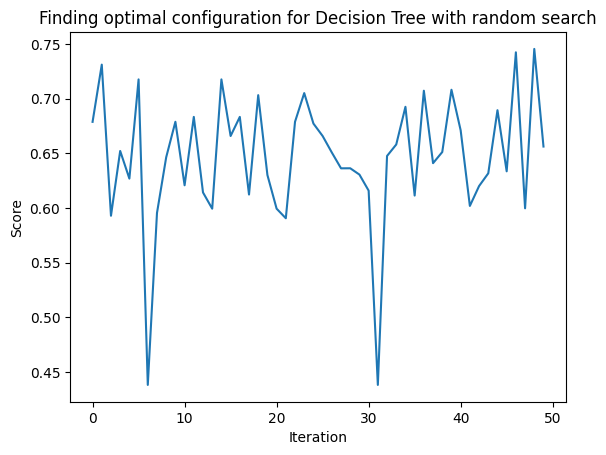

In [10]:
plt.plot(history_scores)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Finding optimal configuration for Decision Tree with random search")
plt.show()

In [11]:
print(optimal_config_decision_tree)
print(best_summary_score_decision_tree)

{'model__ccp_alpha': 0.1, 'model__max_depth': 12, 'model__min_samples_split': 14, 'model__min_samples_leaf': 8}
0.7454811826282407


## Evaluate model with optimal hyperparameters on each dataset

In [12]:
for train_dataset, test_dataset in zip(get_train_datasets(), get_test_datasets()):
    optimal_model: Pipeline = get_decision_tree_pipeline()
    optimal_model.set_params(**optimal_config_decision_tree)
    optimal_model.fit(train_dataset[0], train_dataset[1])
    score = optimal_model.score(test_dataset[0], test_dataset[1])
    print("Optimal decision tree score on dataset : " + str(score))

Optimal decision tree score on dataset : 0.9478807259710302
Optimal decision tree score on dataset : 0.9174357320922341
Optimal decision tree score on dataset : 0.400151089823659
Optimal decision tree score on dataset : 0.6461892689565107
Optimal decision tree score on dataset : 0.5670364411402389
Optimal decision tree score on dataset : 0.7828927482888243
Optimal decision tree score on dataset : 0.957320355809292


## Find best hyperparameters for given dataset with random search

In [13]:
# find tate^(j)*
(
    best_decision_tree_configs_for_each_dataset,
    list_iteration_scores,
) = find_best_configs_in_search_space_with_random_search(
    pipeline=get_decision_tree_pipeline(),
    config_space=get_parameter_grid_decision_tree(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)
for i, iteration_scores in enumerate(list_iteration_scores):
    dump_scores_to_csv(
        iteration_scores,
        f"output_data/decision_tree/random_search_iteration_scores_dataset_{i}.csv",
    )

dataset: 0
score: 0.9643548213621457
best config: {'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 5, 'model__min_samples_split': 16, 'model__min_samples_leaf': 4}
dataset: 1
score: 0.917435732092234
best config: {'model__ccp_alpha': 0.1, 'model__max_depth': 12, 'model__min_samples_split': 14, 'model__min_samples_leaf': 8}
dataset: 2
score: 0.46184442507636947
best config: {'model__ccp_alpha': 0.4, 'model__max_depth': 18, 'model__min_samples_split': 51, 'model__min_samples_leaf': 6}
dataset: 3
score: 0.698117764128138
best config: {'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 5, 'model__min_samples_split': 16, 'model__min_samples_leaf': 4}
dataset: 4
score: 0.5694226766895742
best config: {'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 5, 'model__min_samples_split': 16, 'model__min_samples_leaf': 4}
dataset: 5
score: 0.8431601442240128
best config: {'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 5, 'model__min_samples_split': 16, 'mo

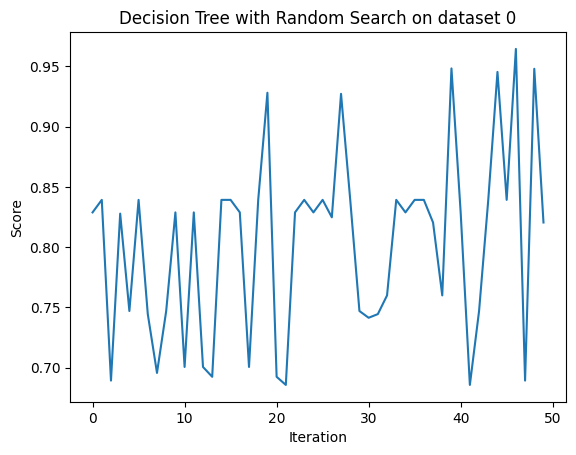

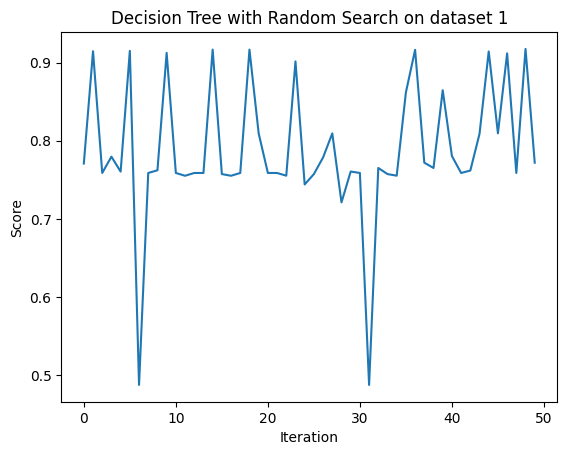

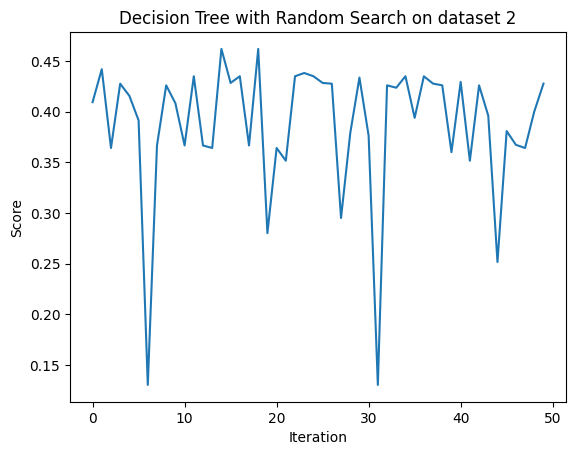

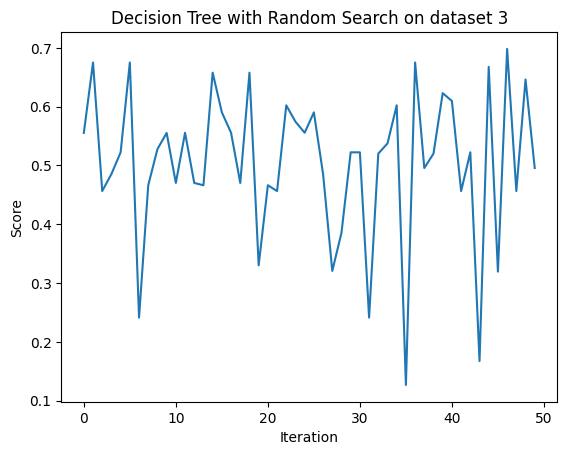

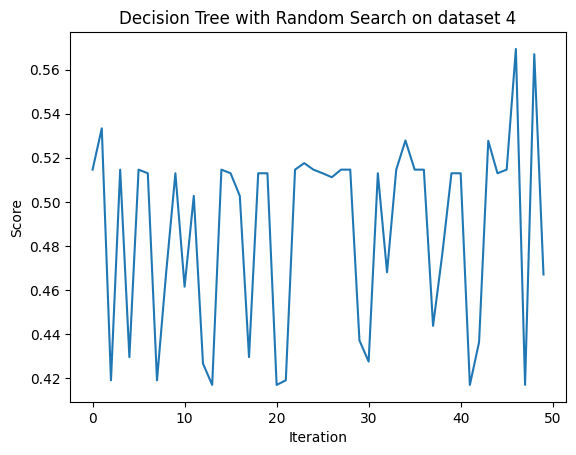

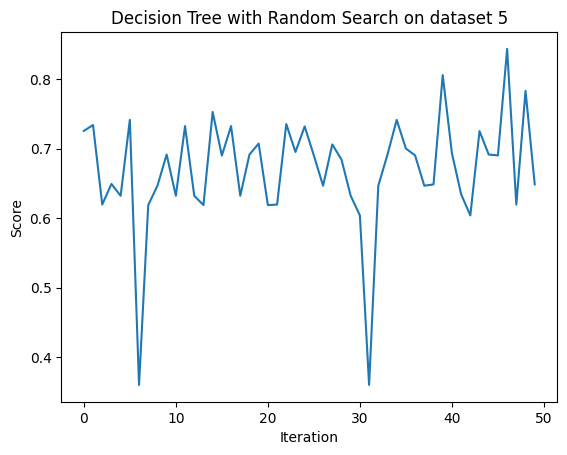

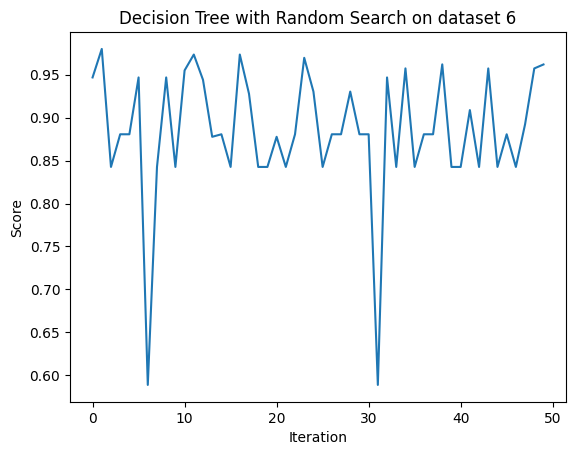

In [14]:
for i, iteration_scores in enumerate(list_iteration_scores):
    plt.plot(iteration_scores)
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Decision Tree with Random Search on dataset {i}")
    plt.show()

## Calculate tunability on each dataset

In [15]:
# find d^j
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_decision_tree_configs_for_each_dataset,
    optimal_config=optimal_config_decision_tree,
    get_model_pipeline=get_decision_tree_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/decision_tree/random_search_tunability.csv",
)

d^j: -0.01647409539111544
d^j: 0.0
d^j: -0.06169333525271048
d^j: -0.05246657885573014
d^j: -0.0023862355493354803
d^j: -0.060267395935188595
d^j: -0.022763875680521517


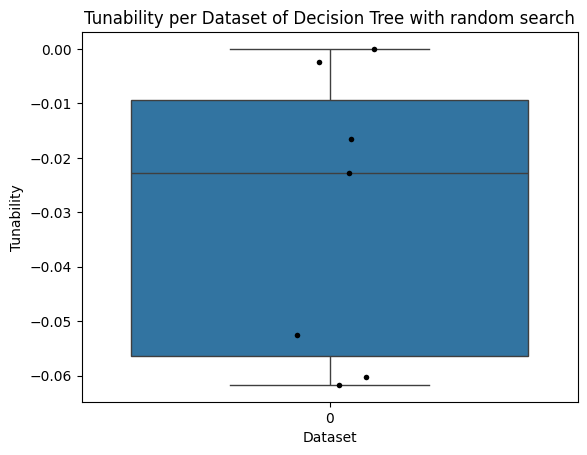

In [16]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of Decision Tree with random search")

# show the plot
plt.show()

In [17]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: -0.03086450238065738


## Find best hyperparameters for given dataset with bayesian search

In [18]:
def get_bayes_search_space_decision_tree():
    return (
        {
            "model__ccp_alpha": Real(0.0, 1.0),
            "model__max_depth": Integer(1, 30),
            "model__min_samples_split": Integer(2, 60),
            "model__min_samples_leaf": Integer(1, 60),
        },
        NUM_ITER_BAYES,
    )

In [19]:
np.int = np.int64  # hack so numpy doesn't complain about missing np.int :)
# calculate all configs
(
    best_configs_for_decision_tree,
    histories,
) = find_best_configs_in_search_space_with_bayes(
    search_space=get_bayes_search_space_decision_tree(),
    pipeline=get_decision_tree_pipeline(),
    train_datasets=get_train_datasets(),
)
for i, history in enumerate(histories):
    dump_scores_to_csv(
        history, f"output_data/decision_tree/bayes_iteration_scores_dataset_{i}.csv"
    )

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = 0.8618046493363021
Iteration 2: Score = 0.7765091670213871
Iteration 3: Score = -0.05320919309927987
Iteration 4: Score = 0.6166370611377376
Iteration 5: Score = 0.7781497879594955
Iteration 6: Score = 0.7913990245351916
Iteration 7: Score = 0.6258598490743615
Iteration 8: Score = 0.8608785161210595
Iteration 9: Score = 0.893366277749194
Iteration 10: Score = 0.872978396636084
Iteration 11: Score = 0.6938644238320535
Iteration 12: Score = 0.6938644238320535
Iteration 13: Score = 0.6938644238320535
Iteration 14: Score = 0.6938644238320535
Iteration 15: Score = 0.891050557131708
Iteration 16: Score = 0.7819467475731763
Iteration 17: Score = 0.7772948803981256
Iteration 18: Score = 0.9270584154741359
Iteration 19: Score = 0.7865466239620986
Iteration 20: Score = -0.05320919309927987
Iteration 21: Score = 0.9080386628214614
Iteration 22: Score = 0.7819467475731763
Iteration 23: Score = 0.7819467475731763
Iteration 24: Score = 0.9656080322153728
Iteration 25: Score = 0.

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = 0.7487772833917775
Iteration 2: Score = 0.7464422552709598
Iteration 3: Score = 0.7327128428176481
Iteration 4: Score = 0.8309223467703186
Iteration 5: Score = 0.7461069715960962
Iteration 6: Score = 0.778924694394618
Iteration 7: Score = 0.8447334929885788
Iteration 8: Score = 0.7748790305328666
Iteration 9: Score = 0.7792890928738874
Iteration 10: Score = 0.7672477800471478
Iteration 11: Score = 0.8104132638705857
Iteration 12: Score = 0.8585182673762889
Iteration 13: Score = 0.859424018449617
Iteration 14: Score = 0.8098445652400409
Iteration 15: Score = 0.8618318499672666
Iteration 16: Score = 0.7827464196022115
Iteration 17: Score = 0.9084773393530259
Iteration 18: Score = 0.9161548868299537
Iteration 19: Score = 0.38802596751508817
Iteration 20: Score = 0.7561747417272262
Iteration 21: Score = 0.8894510232803874
Iteration 22: Score = 0.9201884415795833
Iteration 23: Score = 0.6843672010227231
Iteration 24: Score = 0.9292107170429749
Iteration 25: Score = 0.93

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 1: Score = 0.3607411589080864
Iteration 2: Score = 0.3705058565591358
Iteration 3: Score = 0.43902437961315827
Iteration 4: Score = 0.4383480786937529
Iteration 5: Score = 0.33434868221557956
Iteration 6: Score = 0.35964245675382644
Iteration 7: Score = 0.34016305949982667
Iteration 8: Score = 0.3182299904563064
Iteration 9: Score = 0.35835357406937485
Iteration 10: Score = 0.2978611874828253
Iteration 11: Score = 0.44238877864335907
Iteration 12: Score = 0.42843100406666956
Iteration 13: Score = 0.40241101484342695
Iteration 14: Score = 0.4203466124591938
Iteration 15: Score = 0.4105978416260657
Iteration 16: Score = 0.37470194749935004
Iteration 17: Score = 0.3426622374103614
Iteration 18: Score = 0.4167255886006001
Iteration 19: Score = 0.43703197742220434
Iteration 20: Score = 0.3403321008165838
Iteration 21: Score = 0.452479521979121
Iteration 22: Score = 0.4677145773437624
Iteration 23: Score = 0.41711612685828303
Iteration 24: Score = 0.4364572147412148
Iteration 25: S

### Plot bayes optimization history for each dataset

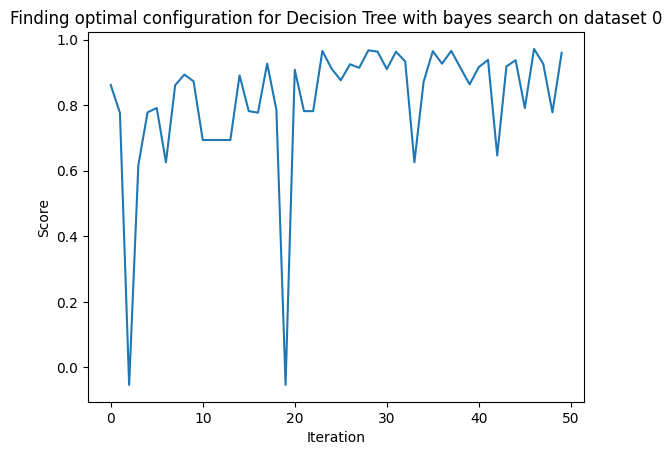

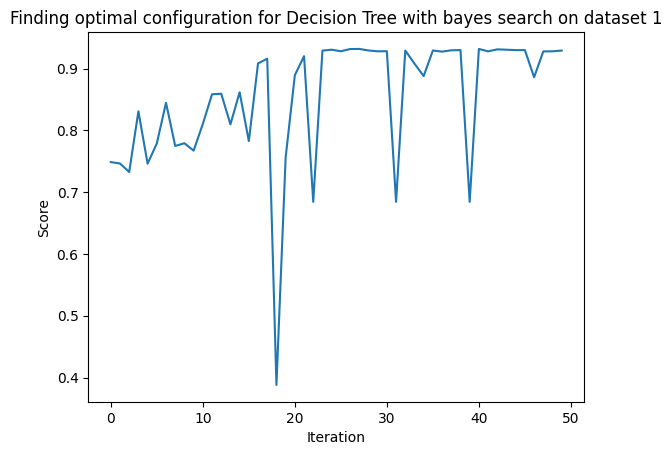

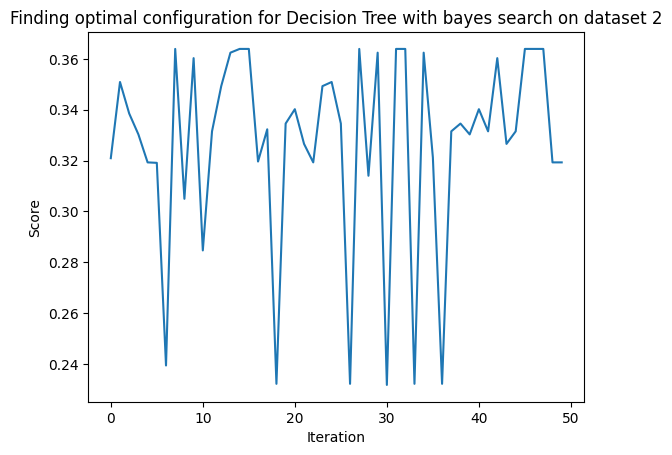

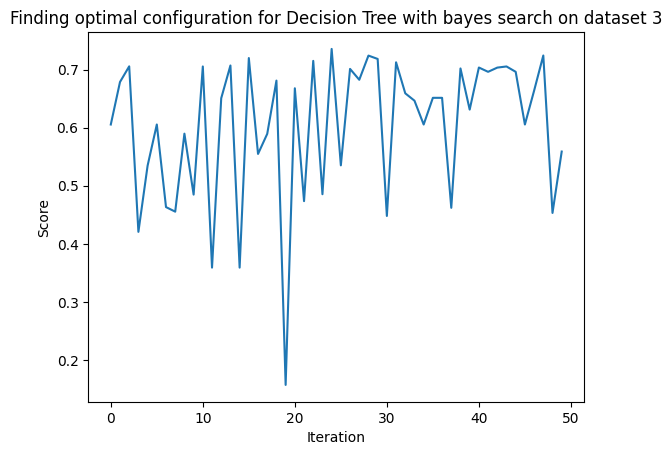

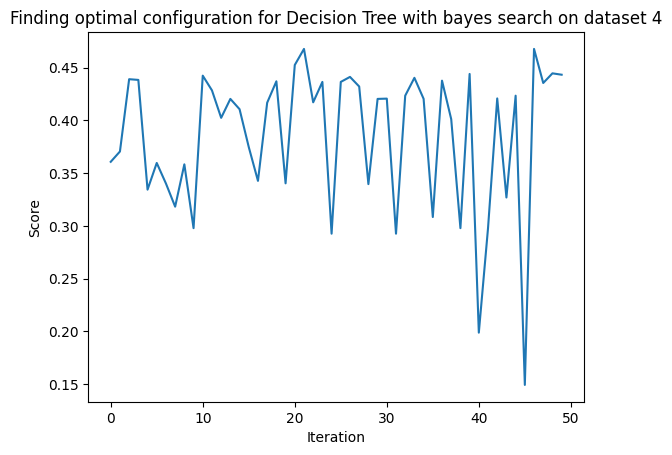

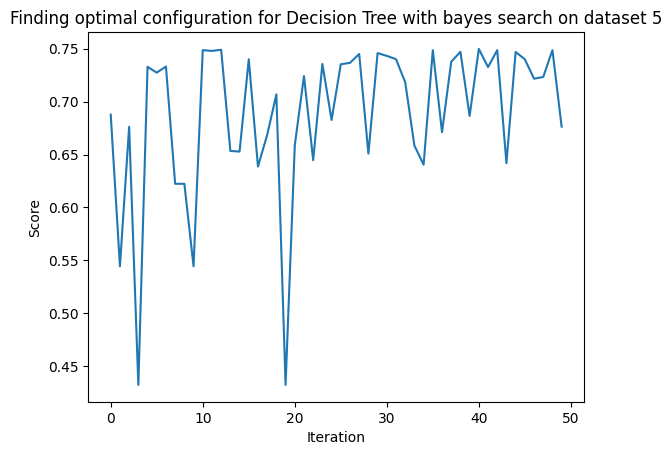

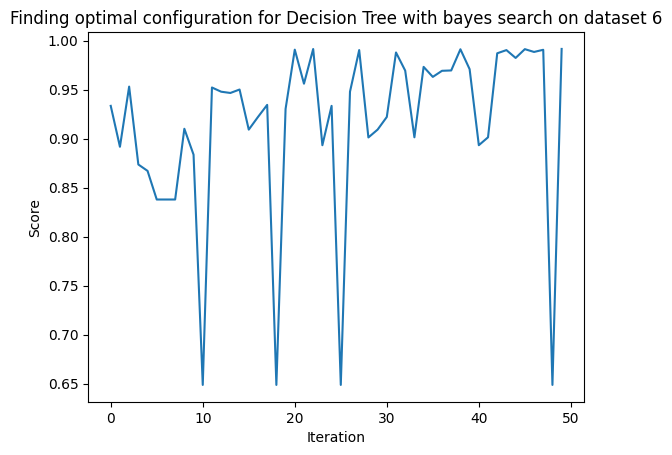

In [20]:
for i in range(len(histories)):
    plt.plot(histories[i])
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(
        f"Finding optimal configuration for Decision Tree with bayes search on dataset {i}"
    )
    plt.show()

## Calculate tunability on each dataset

In [21]:
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_configs_for_decision_tree,
    optimal_config=optimal_config_decision_tree,
    get_model_pipeline=get_decision_tree_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/decision_tree/bayes_tunability.csv",
)

d^j: 0.001011271936315672
d^j: -0.024549966963031356
d^j: 0.03349353735343508
d^j: 0.040283743921068926
d^j: 0.04431557410510323
d^j: 0.035685527028508024
d^j: -0.027616344389975178


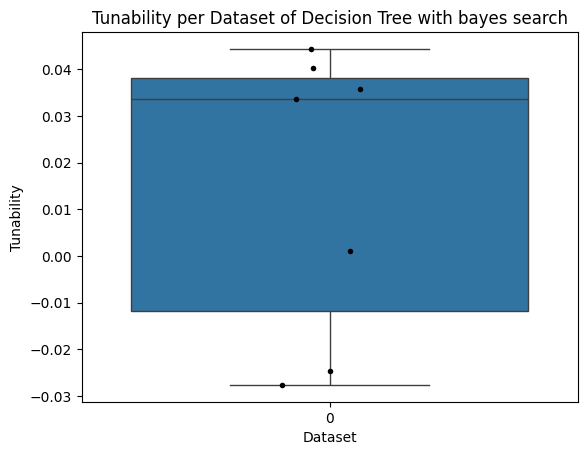

In [22]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of Decision Tree with bayes search")

# show the plot
plt.show()

In [23]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: 0.014660477570203485


# 2. ElasticNet

## Prepare model and search space

In [24]:
def get_elasticnet_pipeline() -> Pipeline:
    elastic_net = ElasticNet(max_iter=10000)
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", elastic_net)]
    )
    return decision_tree_pipeline

In [25]:
def get_parameter_grid_for_elasticnet():
    # parameters space
    random.seed(SEED)
    alpha = [2**i for i in range(-10, 11, 1)]
    l1_ratio = [i * 0.05 for i in range(21)]
    all_combinations = list(
        itertools.product(
            alpha,
            l1_ratio,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, NUM_POINTS_RS_ELASTIC_NET
    )
    parameter_names = [
        "model__alpha",
        "model__l1_ratio",
    ]

    parameters_grid_elasticnet = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_elasticnet

## Find optimal default hyperparameters 

In [28]:
# find teta*

(
    optimal_config_elasticnet,
    best_summary_score_elasticnet,
    history_scores,
) = find_optimal_configuration_for_all_datasets(
    config_space=get_parameter_grid_for_elasticnet(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    model=get_elasticnet_pipeline(),
    summary_func=np.mean,  # Or np.median for a more robust approach
)
dump_optimal_config_search_history(
    history_scores, "output_data/elasticnet/optimal_config_search_history.csv"
)

0
1


2
3
4
5


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.662e+08, tolerance: 5.962e+06
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.860e+11, tolerance: 4.005e+09
  model = cd_fast.enet_coordinate_descent(


6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.793e+06, tolerance: 1.561e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.976e+10, tolerance: 5.962e+06 Linear reg

39
40
41
42
43
44
45
46
47
48
49


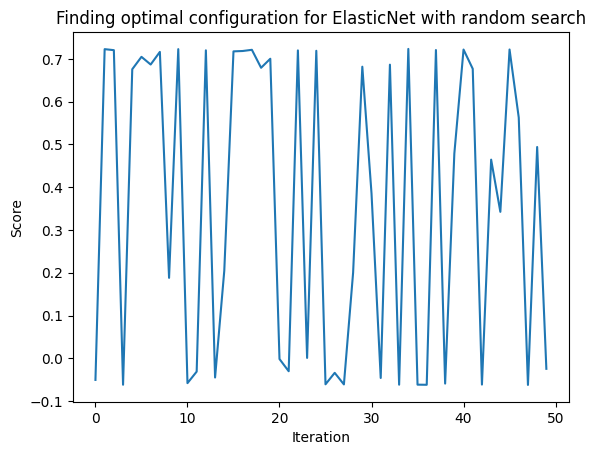

In [29]:
plt.plot(history_scores)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Finding optimal configuration for ElasticNet with random search")
plt.show()

In [30]:
print(optimal_config_elasticnet)
print(best_summary_score_elasticnet)

{'model__alpha': 0.0009765625, 'model__l1_ratio': 0.15000000000000002}
0.723080523481589


## Evaluate model with optimal hyperparameters on each dataset

In [31]:
for train_dataset, test_dataset in zip(get_train_datasets(), get_test_datasets()):
    optimal_model: Pipeline = get_elasticnet_pipeline()
    optimal_model.set_params(**optimal_config_elasticnet)
    optimal_model.fit(train_dataset[0], train_dataset[1])
    score = optimal_model.score(test_dataset[0], test_dataset[1])
    print("Optimal elasticnet score on dataset : " + str(score))

Optimal elasticnet score on dataset : 0.9498813839291849
Optimal elasticnet score on dataset : 0.9232679918840747
Optimal elasticnet score on dataset : 0.4566286471067492
Optimal elasticnet score on dataset : 0.5445476360592428
Optimal elasticnet score on dataset : 0.5581866568920202
Optimal elasticnet score on dataset : 0.6373165272340349
Optimal elasticnet score on dataset : 0.9917348212658172


## Find best hyperparameters for given dataset with random search

In [32]:
# find tate^(j)*
(
    best_elasticnet_configs_for_each_dataset,
    list_iteration_scores,
) = find_best_configs_in_search_space_with_random_search(
    pipeline=get_elasticnet_pipeline(),
    config_space=get_parameter_grid_for_elasticnet(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)
for i, iteration_scores in enumerate(list_iteration_scores):
    dump_scores_to_csv(
        iteration_scores,
        f"output_data/elasticnet/random_search_iteration_scores_dataset_{i}.csv",
    )

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.793e+06, tolerance: 1.561e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


dataset: 0
score: 0.9504290627927017
best config: {'model__alpha': 0.0078125, 'model__l1_ratio': 0.8}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.662e+08, tolerance: 5.962e+06
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.976e+10, tolerance: 5.962e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = 

dataset: 1
score: 0.9239271647899755
best config: {'model__alpha': 0.03125, 'model__l1_ratio': 1.0}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.072e+06, tolerance: 2.145e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


dataset: 2
score: 0.4608813604104236
best config: {'model__alpha': 0.03125, 'model__l1_ratio': 0.7000000000000001}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.860e+11, tolerance: 4.005e+09
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e+13, tolerance: 4.005e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = 

dataset: 3
score: 0.5538581133434504
best config: {'model__alpha': 0.00390625, 'model__l1_ratio': 0.5}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.572e+03, tolerance: 3.145e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


dataset: 4
score: 0.5636432956877125
best config: {'model__alpha': 0.0009765625, 'model__l1_ratio': 0.8}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.753e+04, tolerance: 3.510e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


dataset: 5
score: 0.6524487643894683
best config: {'model__alpha': 0.0078125, 'model__l1_ratio': 0.4}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.750e+03, tolerance: 9.548e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


dataset: 6
score: 0.9926934600160636
best config: {'model__alpha': 0.0009765625, 'model__l1_ratio': 0.8}


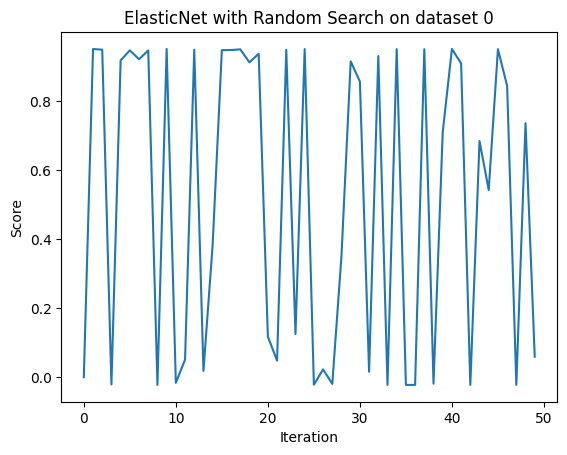

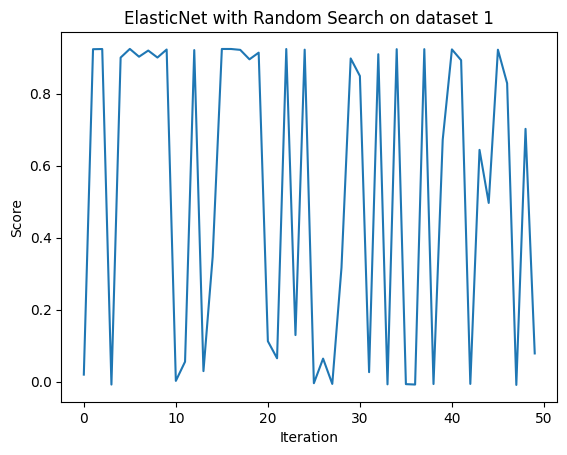

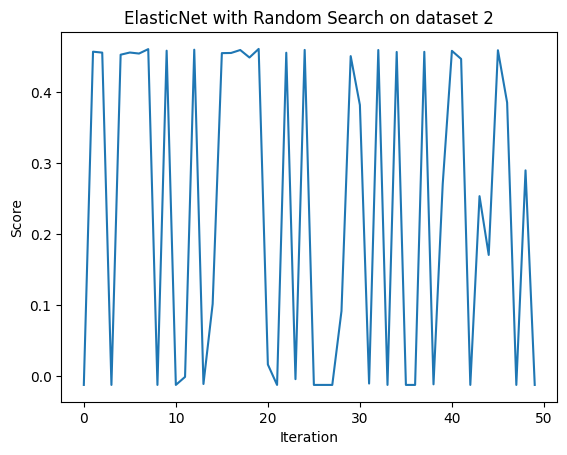

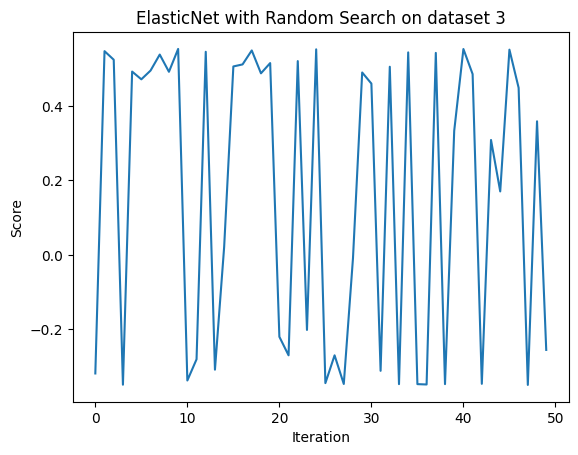

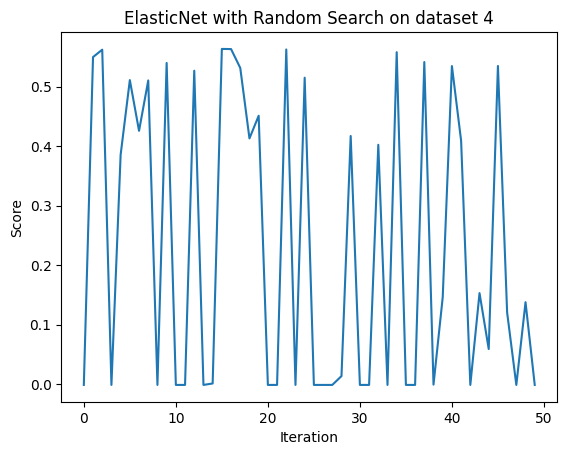

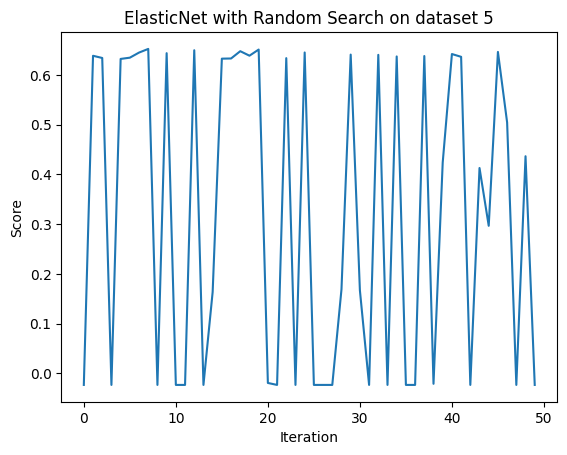

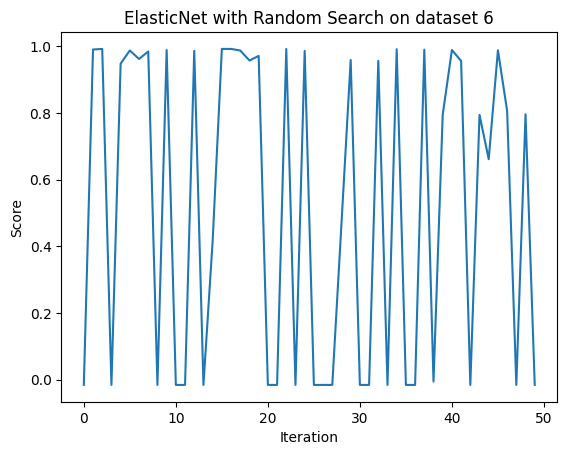

In [33]:
for i, iteration_scores in enumerate(list_iteration_scores):
    plt.plot(iteration_scores)
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"ElasticNet with Random Search on dataset {i}")
    plt.show()

## Calculate tunability on each dataset

In [34]:
# find d^j

tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_elasticnet_configs_for_each_dataset,
    optimal_config=optimal_config_elasticnet,
    get_model_pipeline=get_elasticnet_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/elasticnet/random_search_tunability.csv",
)

d^j: -0.0005476788635168095


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.662e+08, tolerance: 5.962e+06
  model = cd_fast.enet_coordinate_descent(


d^j: -0.0006591729059007845
d^j: -0.0042527133036743825
d^j: -0.00931047728420753
d^j: -0.005456638795692359
d^j: -0.015132237155433437
d^j: -0.0009586387502463767


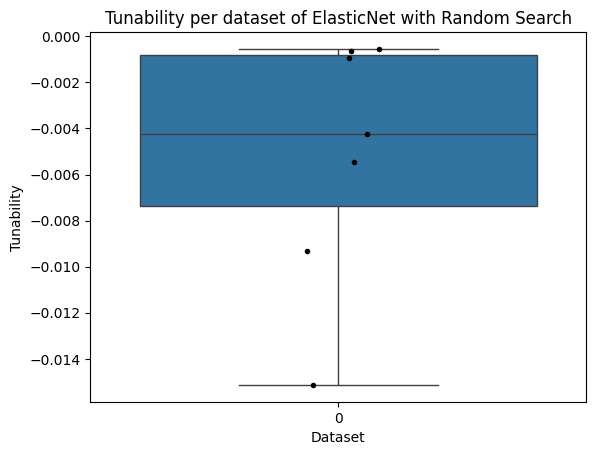

In [35]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per dataset of ElasticNet with Random Search")

# show the plot
plt.show()

In [36]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: -0.005188222436953097


## Find best hyperparameters for given dataset with bayesian search


In [62]:
def get_bayes_search_space_elasticnet():
    return (
        {
            "model__alpha": Real(2 ** (-10), 2**10),
            "model__l1_ratio": Real(0.0, 1.0),
        },
        NUM_ITER_BAYES,
    )

In [63]:
np.int = np.int64  # hack so numpy doesn't complain about missing np.int :)
# calculate all configs
best_configs_for_elasticnet, histories = find_best_configs_in_search_space_with_bayes(
    search_space=get_bayes_search_space_elasticnet(),
    pipeline=get_elasticnet_pipeline(),
    train_datasets=get_train_datasets(),
)
for i, history in enumerate(histories):
    dump_scores_to_csv(
        history, f"output_data/elasticnet/bayes_iteration_scores_dataset_{i}.csv"
    )

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.05320919309927983
Iteration 2: Score = -0.05320919309927983
Iteration 3: Score = -0.05320919309927983
Iteration 4: Score = -0.05320919309927983
Iteration 5: Score = -0.05320919309927983
Iteration 6: Score = -0.05320919309927983
Iteration 7: Score = -0.05320919309927983
Iteration 8: Score = -0.05320919309927983
Iteration 9: Score = -0.05195868524066825
Iteration 10: Score = -0.05320919309927983
Iteration 11: Score = 0.8428047657318307
Iteration 12: Score = 0.905113651019357
Iteration 13: Score = 0.9101571674898745
Iteration 14: Score = 0.9101571674898745
Iteration 15: Score = 0.9101571674898745
Iteration 16: Score = -0.05320919309927983
Iteration 17: Score = 0.9101571674898745
Iteration 18: Score = 0.9101571674898745
Iteration 19: Score = 0.9101571674898745
Iteration 20: Score = 0.9101571674898745
Iteration 21: Score = 0.9101571674898745
Iteration 22: Score = 0.9101571674898745
Iteration 23: Score = 0.9101571674898745
Iteration 24: Score = 0.9101571674898745
Iter

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.000815391537222343
Iteration 2: Score = 0.002388969831963039
Iteration 3: Score = 0.05459891069423992
Iteration 4: Score = -0.0014438867332317918
Iteration 5: Score = 0.008225586538023345
Iteration 6: Score = -0.001450653713834593
Iteration 7: Score = 0.44425116709836365
Iteration 8: Score = -0.0004707878584299774
Iteration 9: Score = 0.0009295129748110087
Iteration 10: Score = -0.0008791340729335184
Iteration 11: Score = 0.9048563306610411
Iteration 12: Score = 0.44161288551756606
Iteration 13: Score = 0.885848236117418
Iteration 14: Score = 0.9048563306610411
Iteration 15: Score = -0.0015225957270695867
Iteration 16: Score = 0.9048563306610411
Iteration 17: Score = 0.9048563306610411
Iteration 18: Score = 0.9048563306610411
Iteration 19: Score = 0.9048563306610411
Iteration 20: Score = 0.9048563306610411
Iteration 21: Score = 0.9048563306610411
Iteration 22: Score = 0.9048563306610411
Iteration 23: Score = 0.9048563306610411
Iteration 24: Score = 0.90485633066

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.030468644138217815
Iteration 2: Score = -0.030468644138217815
Iteration 3: Score = -0.030468644138217815
Iteration 4: Score = -0.030468644138217815
Iteration 5: Score = -0.030468644138217815
Iteration 6: Score = -0.030468644138217815
Iteration 7: Score = -0.030468644138217815
Iteration 8: Score = -0.030468644138217815
Iteration 9: Score = -0.030468644138217815
Iteration 10: Score = -0.030468644138217815
Iteration 11: Score = -0.03036806111659156
Iteration 12: Score = -0.030468644138217815
Iteration 13: Score = -0.030468644138217815
Iteration 14: Score = -0.026818334879842774
Iteration 15: Score = 0.45343038779106803
Iteration 16: Score = 0.45343038779106803
Iteration 17: Score = 0.09087612010434025
Iteration 18: Score = 0.02402711071612209
Iteration 19: Score = 0.45343038779106803
Iteration 20: Score = 0.45294164315463653
Iteration 21: Score = -0.01752281859712703
Iteration 22: Score = 0.45254316576574133
Iteration 23: Score = 0.4493817031984519
Iteration 24: Sc

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.08486409062656727
Iteration 2: Score = -0.08020389121806118
Iteration 3: Score = -0.08459968343928588
Iteration 4: Score = -0.07851016552593681
Iteration 5: Score = -0.08525872807339865
Iteration 6: Score = -0.08128058886306617
Iteration 7: Score = -0.08519120705604503
Iteration 8: Score = -0.08408127927825096
Iteration 9: Score = -0.08449552530332434
Iteration 10: Score = -0.08495995035447117
Iteration 11: Score = 0.5798864575370019
Iteration 12: Score = 0.5798864575370019
Iteration 13: Score = 0.6134289513968311
Iteration 14: Score = 0.49278989227980025
Iteration 15: Score = 0.6224119916041501
Iteration 16: Score = -0.08553272234838807
Iteration 17: Score = -0.07146096092743129
Iteration 18: Score = 0.5725607226777438
Iteration 19: Score = 0.5672626096918559
Iteration 20: Score = 0.5742224358247375
Iteration 21: Score = 0.49278989227980025
Iteration 22: Score = 0.5798864575370019
Iteration 23: Score = 0.5847762625657926
Iteration 24: Score = 0.5797824158425197

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 1: Score = -0.04783734841928187
Iteration 2: Score = -0.04783734841928187
Iteration 3: Score = -0.04783734841928187
Iteration 4: Score = -0.04783734841928187
Iteration 5: Score = -0.04783734841928187
Iteration 6: Score = -0.04783734841928187
Iteration 7: Score = -0.04783734841928187
Iteration 8: Score = -0.04783734841928187
Iteration 9: Score = -0.04783734841928187
Iteration 10: Score = -0.04783734841928187
Iteration 11: Score = -0.04783734841928187
Iteration 12: Score = -0.04783734841928187
Iteration 13: Score = 0.5169495900300881
Iteration 14: Score = 0.5169495900300881
Iteration 15: Score = 0.5169495900300881
Iteration 16: Score = 0.5171492934697689
Iteration 17: Score = -0.04783734841928187
Iteration 18: Score = -0.030134167023268675
Iteration 19: Score = -0.04783734841928187
Iteration 20: Score = 0.5171611726457964
Iteration 21: Score = -0.04783734841928187
Iteration 22: Score = 0.5171553887562463
Iteration 23: Score = -0.04783734841928187
Iteration 24: Score = -0.047837

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.007952659633162319
Iteration 2: Score = -0.007952659633162319
Iteration 3: Score = -0.007952659633162319
Iteration 4: Score = -0.007952659633162319
Iteration 5: Score = -0.007952659633162319
Iteration 6: Score = -0.007952659633162319
Iteration 7: Score = -0.007952659633162319
Iteration 8: Score = -0.007952659633162319
Iteration 9: Score = -0.007952659633162319
Iteration 10: Score = -0.007952659633162319
Iteration 11: Score = 0.2045693779216597
Iteration 12: Score = 0.7121229943426186
Iteration 13: Score = 0.7118845556843579
Iteration 14: Score = 0.7119003390844194
Iteration 15: Score = 0.7118201274913067
Iteration 16: Score = 0.7118165900722554
Iteration 17: Score = 0.7117563562340096
Iteration 18: Score = 0.7118392236617757
Iteration 19: Score = 0.7118368724153111
Iteration 20: Score = 0.7117222795316553
Iteration 21: Score = 0.7117306330515084
Iteration 22: Score = 0.7118175369220243
Iteration 23: Score = 0.7117314427418158
Iteration 24: Score = -0.00795265963

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluate

Iteration 1: Score = -0.0028718766188328805
Iteration 2: Score = -0.0028718766188328805
Iteration 3: Score = -0.0028718766188328805
Iteration 4: Score = -0.0028718766188328805
Iteration 5: Score = -0.0028718766188328805
Iteration 6: Score = -0.0028718766188328805
Iteration 7: Score = -0.0028718766188328805
Iteration 8: Score = -0.0028718766188328805
Iteration 9: Score = -0.0028718766188328805
Iteration 10: Score = -0.0028718766188328805
Iteration 11: Score = 0.1734887922255267
Iteration 12: Score = 0.9950214740972049
Iteration 13: Score = 0.9950182803794224
Iteration 14: Score = -0.0028718766188328805
Iteration 15: Score = -0.0028718766188328805
Iteration 16: Score = -0.0028718766188328805
Iteration 17: Score = 0.9950214740972049
Iteration 18: Score = 0.9946190144735167
Iteration 19: Score = -0.0028718766188328805
Iteration 20: Score = 0.9939682059870357
Iteration 21: Score = -0.0028718766188328805
Iteration 22: Score = 0.9948998723089415
Iteration 23: Score = 0.9939682059870357
Iterat

### Plot bayes optimization history for each dataset

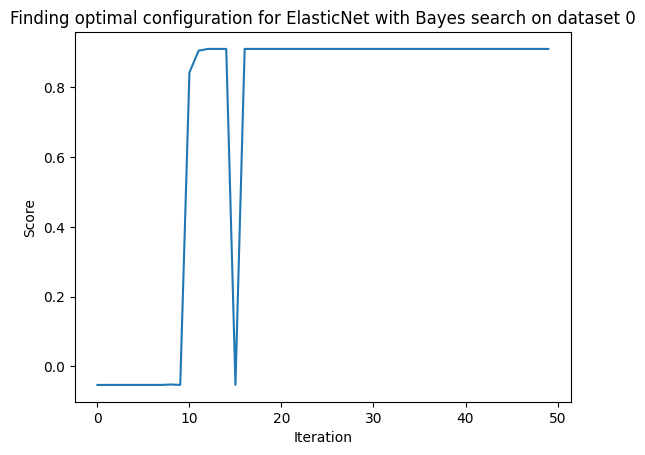

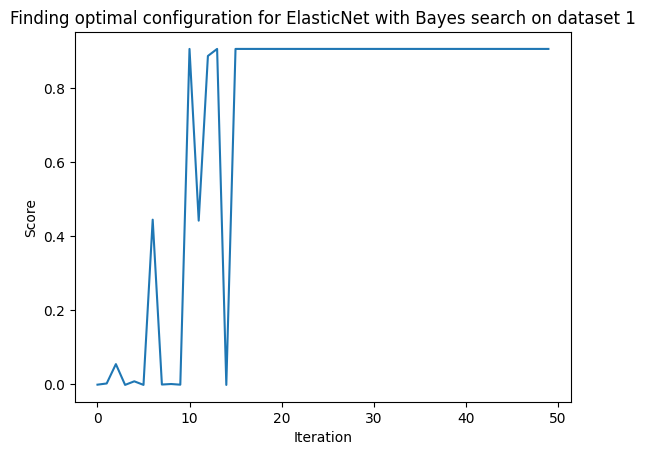

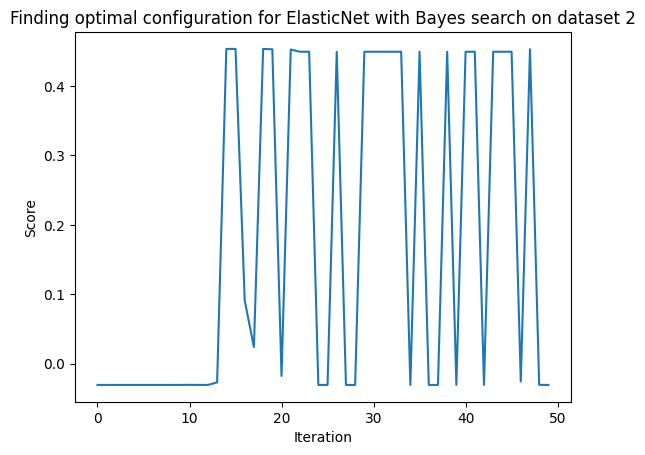

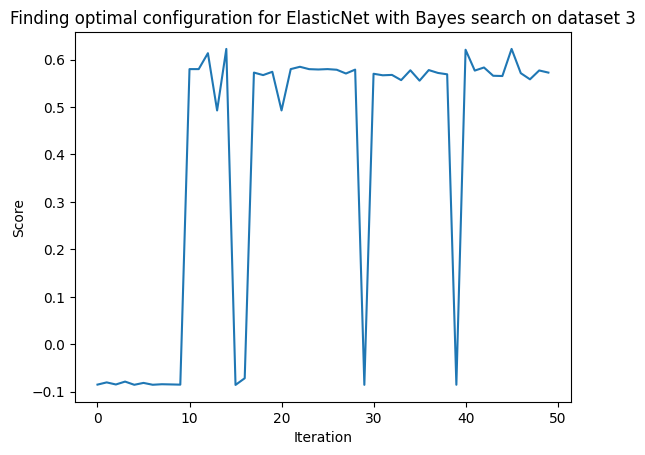

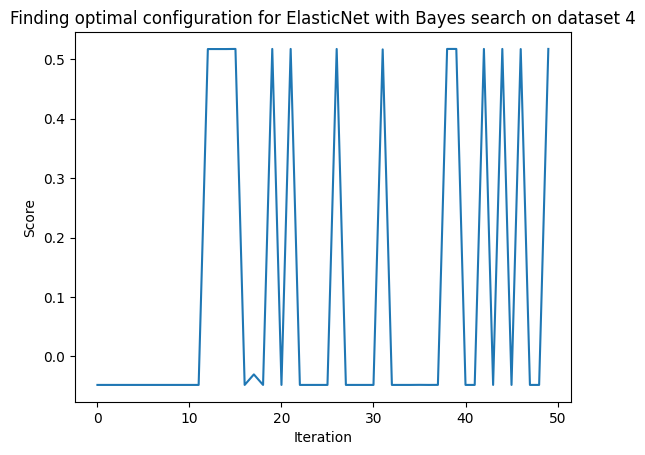

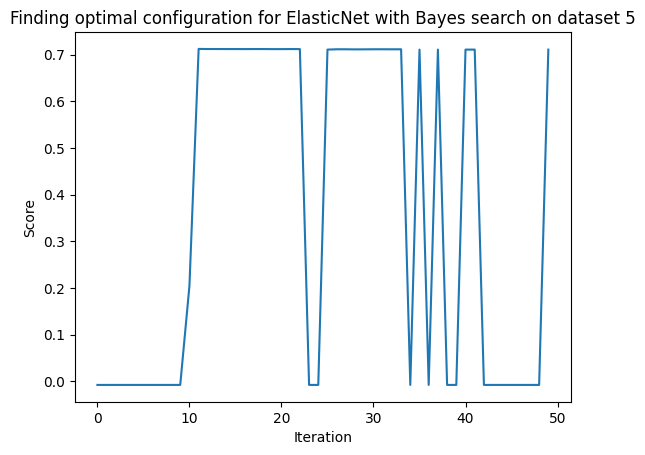

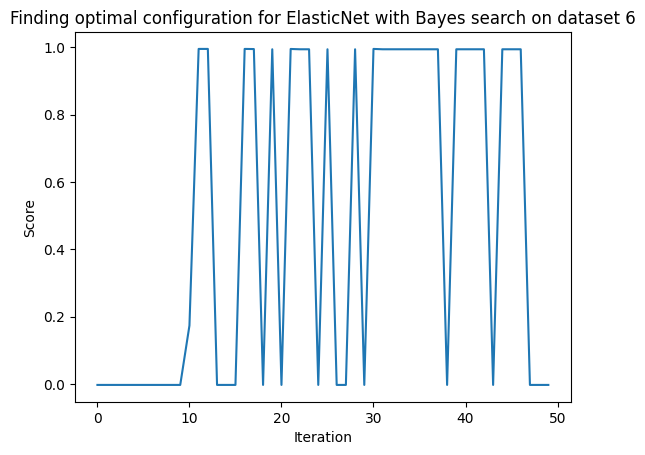

In [64]:
for i in range(len(histories)):
    plt.plot(histories[i])
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(
        f"Finding optimal configuration for ElasticNet with Bayes search on dataset {i}"
    )
    plt.show()

## Calculate tunability on each dataset

In [65]:
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_configs_for_elasticnet,
    optimal_config=optimal_config_elasticnet,
    get_model_pipeline=get_elasticnet_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/elasticnet/bayes_tunability.csv",
)

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.674e+05, tolerance: 1.561e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


d^j: -0.0002745708005447156


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.341e+08, tolerance: 5.962e+06
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.182e+05, tolerance: 2.145e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = 

d^j: -0.0006609589369501734
d^j: -0.0002498889160280626
d^j: 0.016305953922030603
d^j: -0.005644168755942758
d^j: -0.0009519468445448043
d^j: -0.001085578394419251


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.883e+03, tolerance: 3.510e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


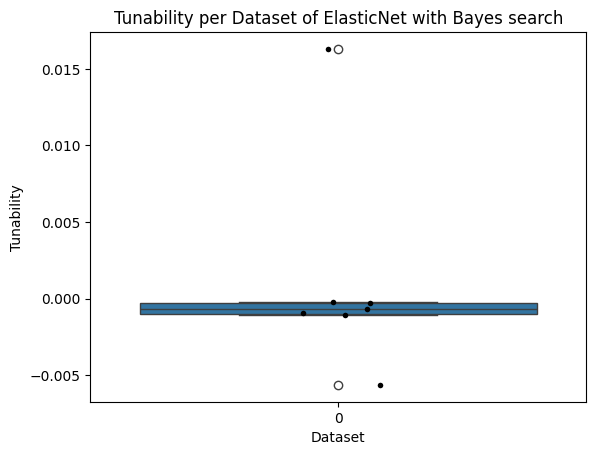

In [66]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of ElasticNet with Bayes search")

# show the plot
plt.show()

In [67]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: 0.0010626916105144055


# 3. Random Forest

## Prepare model and search space

In [43]:
def get_random_forest_pipeline():
    random_forest = RandomForestRegressor(bootstrap=True)
    col_trans: ColumnTransformer = get_column_transformer()
    random_forest_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", random_forest)]
    )
    return random_forest_pipeline

In [44]:
def get_parameter_grid_for_random_forest():
    # parameters space
    random.seed(SEED)
    # max_depth_values = range(1, 31, 1)
    min_samples_split_values = range(2, 528, 5)
    min_samples_leaf_values = range(1, 10, 1)
    n_estimators_values = range(1, 2000, 10)
    max_samples_values = [float(i) * 0.1 for i in range(1, 11, 1)]
    max_features_values = [i for i in range(1, 15, 1)]
    all_combinations = list(
        itertools.product(
            # max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
            n_estimators_values,
            max_samples_values,
            max_features_values,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, NUM_POINTS_RS_RANDOM_FOREST
    )
    parameter_names = [
        # "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
        "model__n_estimators",
        "model__max_samples",
        "model__max_features",
    ]

    parameters_grid_random_forest = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_random_forest

## Find optimal default hyperparameters 

In [45]:
(
    optimal_config_random_forest,
    best_summary_score_random_forest,
    history_scores,
) = find_optimal_configuration_for_all_datasets(
    config_space=get_parameter_grid_for_random_forest(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    model=get_random_forest_pipeline(),
    summary_func=np.mean,  # Or np.median for a more robust approach
)
dump_optimal_config_search_history(
    history_scores, "output_data/random_forest/optimal_config_search_history.csv"
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


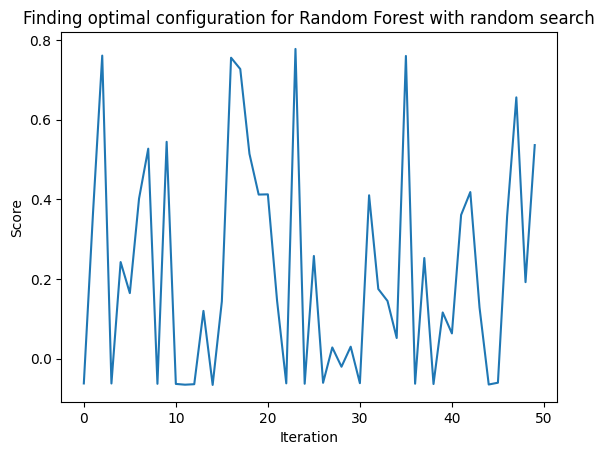

In [46]:
plt.plot(history_scores)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Finding optimal configuration for Random Forest with random search")
plt.show()

In [47]:
print(optimal_config_random_forest)
print(best_summary_score_random_forest)

{'model__min_samples_split': 17, 'model__min_samples_leaf': 5, 'model__n_estimators': 1591, 'model__max_samples': 1.0, 'model__max_features': 14}
0.777482595726086


## Evaluate model with optimal hyperparameters on each dataset

In [48]:
for train_dataset, test_dataset in zip(get_train_datasets(), get_test_datasets()):
    optimal_model: Pipeline = get_random_forest_pipeline()
    optimal_model.set_params(**optimal_config_random_forest)
    optimal_model.fit(train_dataset[0], train_dataset[1])
    score = optimal_model.score(test_dataset[0], test_dataset[1])
    print("Optimal random_forest score on dataset : " + str(score))

Optimal random_forest score on dataset : 0.9602149763722608
Optimal random_forest score on dataset : 0.9211871938309688
Optimal random_forest score on dataset : 0.4734542883527647
Optimal random_forest score on dataset : 0.6627333260238264
Optimal random_forest score on dataset : 0.6097769025166107
Optimal random_forest score on dataset : 0.8309117590612851
Optimal random_forest score on dataset : 0.9902476933864949


## Find best hyperparameters for given dataset with random search

In [49]:
# find tate^(j)*
(
    best_random_forest_configs_for_each_dataset,
    list_iteration_scores,
) = find_best_configs_in_search_space_with_random_search(
    pipeline=get_random_forest_pipeline(),
    config_space=get_parameter_grid_for_random_forest(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)
for i, iteration_scores in enumerate(list_iteration_scores):
    dump_scores_to_csv(
        iteration_scores,
        f"output_data/random_forest/random_search_iteration_scores_dataset_{i}.csv",
    )

dataset: 0
score: 0.9601007142272948
best config: {'model__min_samples_split': 17, 'model__min_samples_leaf': 5, 'model__n_estimators': 1591, 'model__max_samples': 1.0, 'model__max_features': 14}
dataset: 1
score: 0.9190784460940951
best config: {'model__min_samples_split': 17, 'model__min_samples_leaf': 5, 'model__n_estimators': 1591, 'model__max_samples': 1.0, 'model__max_features': 14}
dataset: 2
score: 0.4843823543855986
best config: {'model__min_samples_split': 17, 'model__min_samples_leaf': 3, 'model__n_estimators': 1941, 'model__max_samples': 0.5, 'model__max_features': 6}
dataset: 3
score: 0.6562814637317145
best config: {'model__min_samples_split': 17, 'model__min_samples_leaf': 5, 'model__n_estimators': 1591, 'model__max_samples': 1.0, 'model__max_features': 14}
dataset: 4
score: 0.6075078017041036
best config: {'model__min_samples_split': 17, 'model__min_samples_leaf': 5, 'model__n_estimators': 1591, 'model__max_samples': 1.0, 'model__max_features': 14}
dataset: 5
score: 0.8

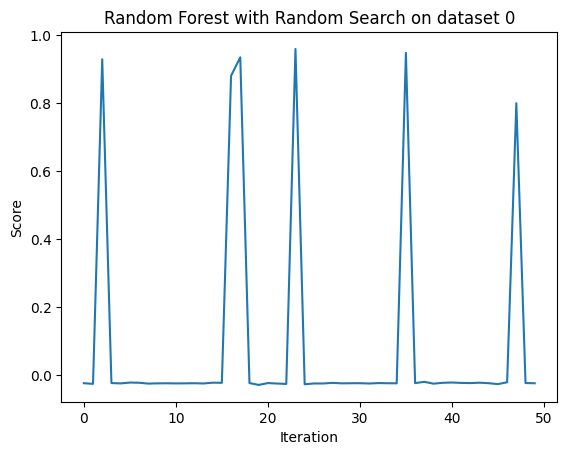

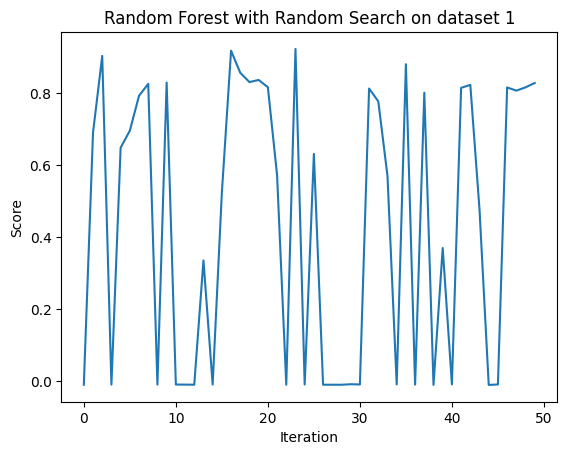

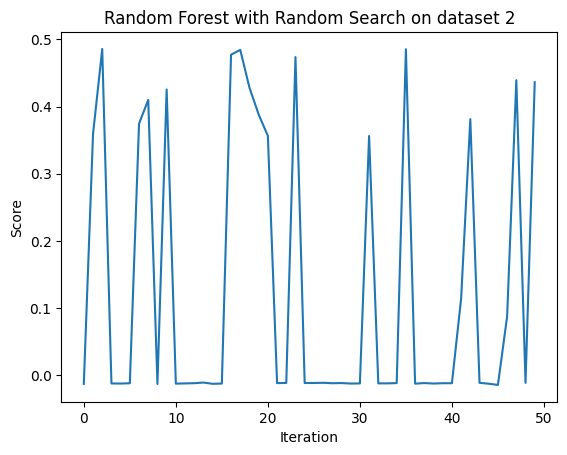

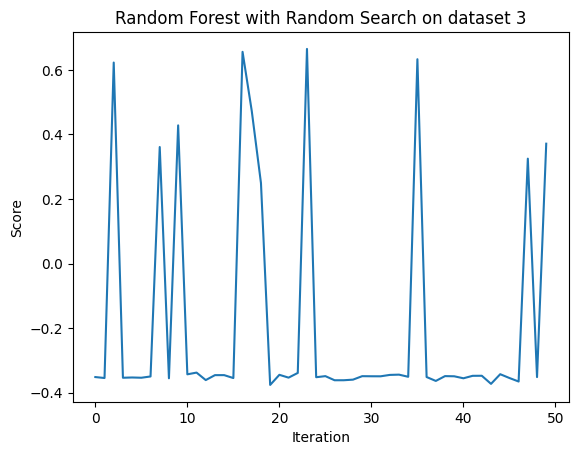

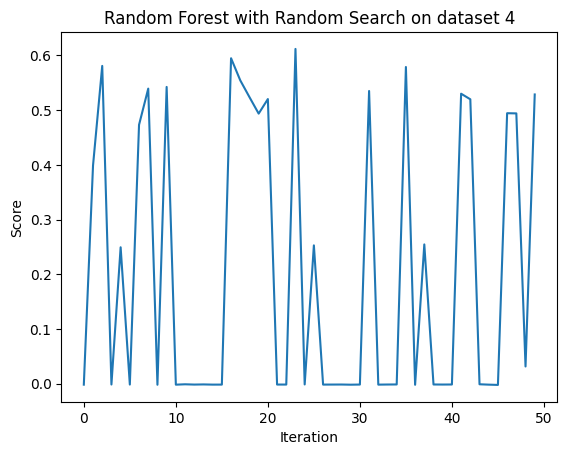

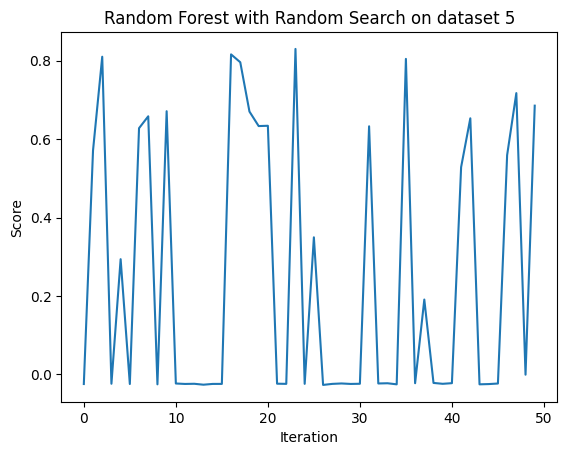

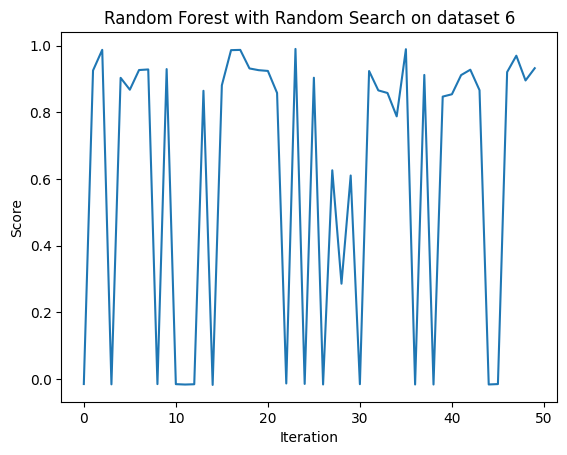

In [50]:
for i, iteration_scores in enumerate(list_iteration_scores):
    plt.plot(iteration_scores)
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Random Forest with Random Search on dataset {i}")
    plt.show()

## Calculate tunability on each dataset

In [51]:
# find d^j

tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_random_forest_configs_for_each_dataset,
    optimal_config=optimal_config_random_forest,
    get_model_pipeline=get_random_forest_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/random_forest/random_search_tunability.csv",
)

d^j: -0.00046707386057087685
d^j: -0.001416217583152135
d^j: -0.00948111941161156
d^j: 0.0025169604578653137
d^j: -0.00028674826508767737
d^j: 0.0014283146257489943
d^j: 0.00012769382073340996


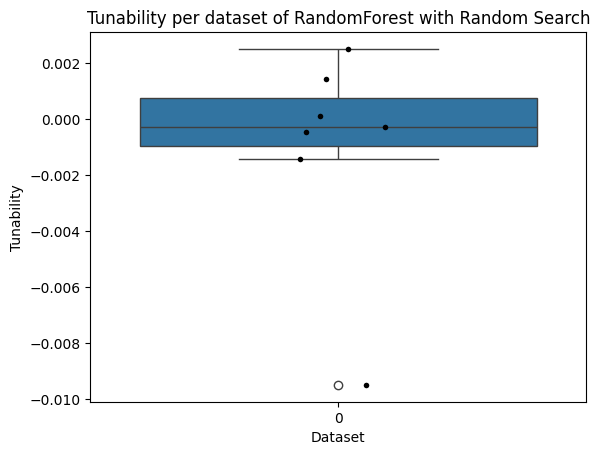

In [52]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per dataset of RandomForest with Random Search")

# show the plot
plt.show()

In [53]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: -0.0010825986022963616


## Find best hyperparameters for given dataset with bayesian search


In [56]:
def get_bayes_search_space_random_forest():
    return (
        {
            "model__min_samples_split": Integer(2, 528),
            "model__min_samples_leaf": Integer(2, 10),
            "model__min_samples_leaf": Integer(1, 60),
            "model__n_estimators": Integer(1, 2000),
            "model__max_samples": Real(0.1, 1.0),
            "model__max_features": Integer(1, 14),
        },
        NUM_ITER_BAYES,
    )

In [57]:
np.int = np.int64  # hack so numpy doesn't complain about missing np.int :)
# calculate all configs
(
    best_configs_for_random_forest,
    histories,
) = find_best_configs_in_search_space_with_bayes(
    search_space=get_bayes_search_space_random_forest(),
    pipeline=get_random_forest_pipeline(),
    train_datasets=get_train_datasets(),
)
for i, history in enumerate(histories):
    dump_scores_to_csv(
        history, f"output_data/random_forest/bayes_iteration_scores_dataset_{i}.csv"
    )

Iteration 1: Score = -0.05088868926772876
Iteration 2: Score = 0.8023698487228728
Iteration 3: Score = -0.053446259827787876
Iteration 4: Score = -0.05362294334943307
Iteration 5: Score = -0.05390905003809458
Iteration 6: Score = -0.05181975511719261
Iteration 7: Score = -0.05049465798166959
Iteration 8: Score = -0.052998725945135126
Iteration 9: Score = -0.053708047821908037
Iteration 10: Score = -0.050016256963794394
Iteration 11: Score = -0.04378795189501785
Iteration 12: Score = -0.052987611933906595
Iteration 13: Score = 0.7312821376855888
Iteration 14: Score = -0.050988826957311814
Iteration 15: Score = -0.05292015451661296
Iteration 16: Score = -0.05324053447447672
Iteration 17: Score = 0.7814782776672287
Iteration 18: Score = 0.8049919648302483
Iteration 19: Score = -0.05465803993792915
Iteration 20: Score = 0.8098647071836638
Iteration 21: Score = -0.05152742277423439
Iteration 22: Score = 0.8039311992264506
Iteration 23: Score = 0.964061855150093
Iteration 24: Score = 0.90056

### Plot bayes optimization history for each dataset

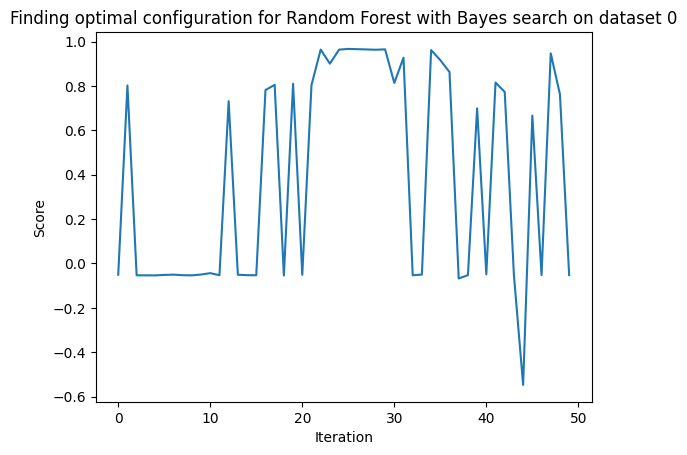

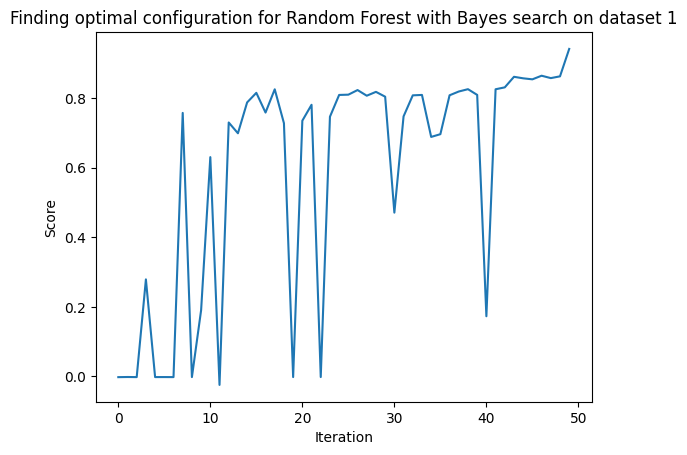

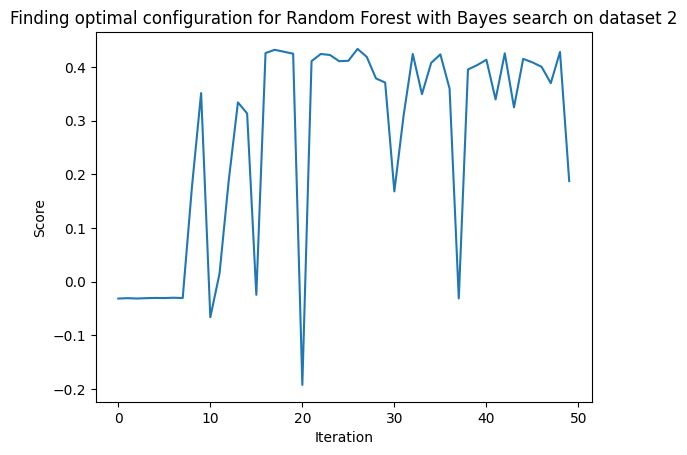

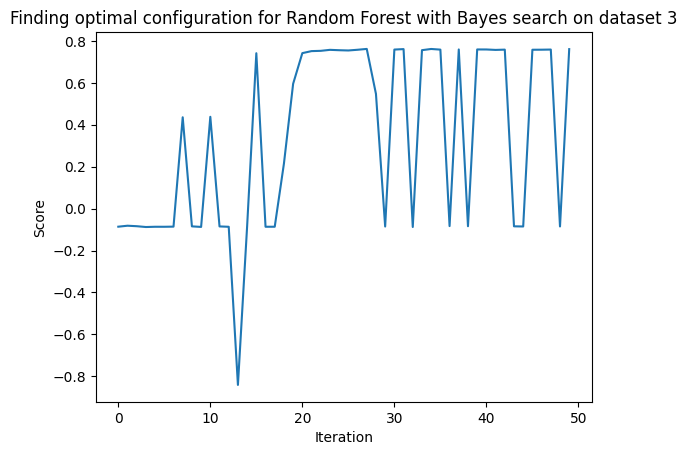

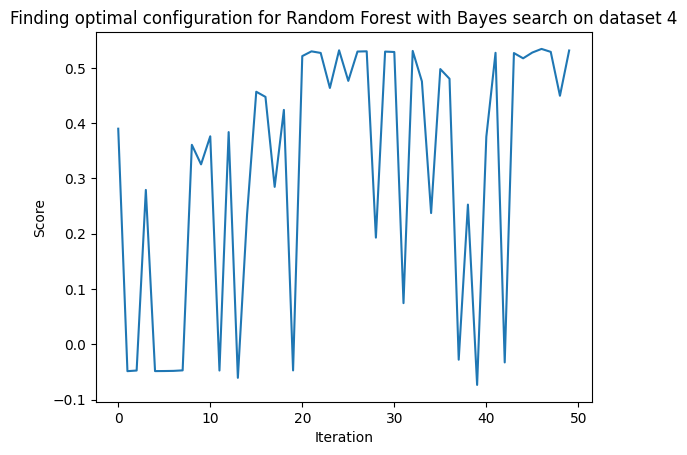

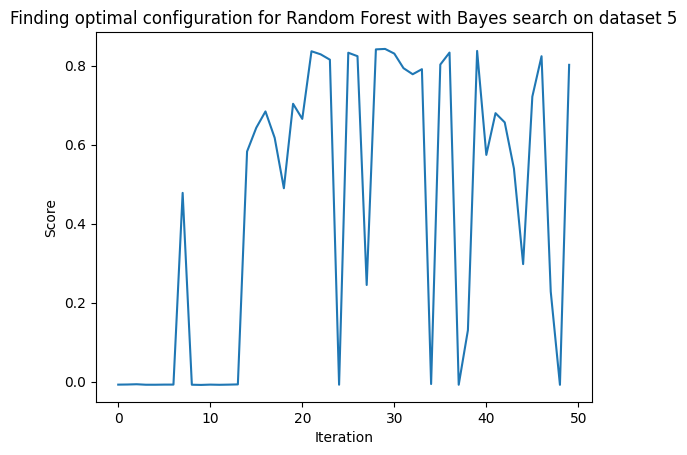

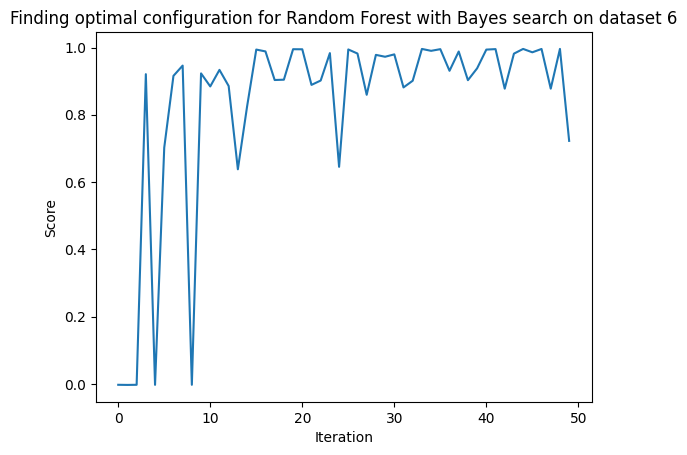

In [58]:
for i in range(len(histories)):
    plt.plot(histories[i])
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(
        f"Finding optimal configuration for Random Forest with Bayes search on dataset {i}"
    )
    plt.show()

## Calculate tunability on each dataset

In [59]:
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_configs_for_random_forest,
    optimal_config=optimal_config_random_forest,
    get_model_pipeline=get_random_forest_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/random_forest/bayes_tunability.csv",
)

d^j: -0.00847783686875081
d^j: -0.034619426323187485
d^j: -0.016149234574838633
d^j: -0.021994341904531867
d^j: 0.00969473439963775
d^j: -0.05596730494727953
d^j: -0.0020016954127379805


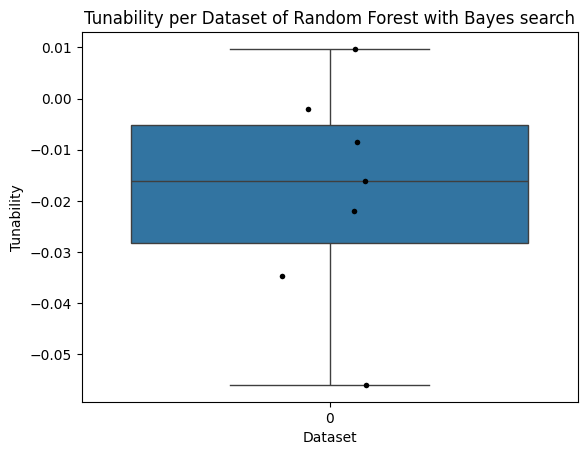

In [60]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of Random Forest with Bayes search")

# show the plot
plt.show()

In [61]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: -0.01850215794738408
